# TIỀN XỬ LÝ DỮ LIỆU VÀ FEATURE ENGINEERING
## Data Preprocessing & Feature Engineering

---

### Mục tiêu
1. Xử lý dữ liệu bất thường và outliers
2. Feature Engineering - Tạo các đặc trưng mới
3. Encoding categorical variables
4. Feature Scaling & Normalization
5. Xử lý Imbalanced Data
6. Train-Test Split
7. Lưu dữ liệu đã xử lý

---

## 1. Import thư viện

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Imbalanced data handling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Import thành công!")

✅ Import thành công!


## 2. Load dữ liệu từ EDA

In [2]:
# Load data
df = pd.read_csv('../data/processed/data_after_eda.csv')
print(f"✅ Đã load dữ liệu: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\nCác cột: {list(df.columns)}")

✅ Đã load dữ liệu: 30,000 rows x 37 columns

Các cột: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default', 'SEX_label', 'EDUCATION_label', 'MARRIAGE_label', 'AGE_GROUP', 'LIMIT_GROUP', 'MAX_PAY_DELAY', 'AVG_PAY_DELAY', 'PAY_DELAY_SUM', 'AVG_BILL_AMT', 'AVG_PAY_AMT', 'UTILIZATION_RATE', 'PAYMENT_RATIO']


## 3. Xử lý dữ liệu bất thường

In [3]:
print("=" * 60)
print("XỬ LÝ DỮ LIỆU BẤT THƯỜNG")
print("=" * 60)

# 1. Fix EDUCATION values (0, 5, 6 -> 4 = Other)
print("\n1. Xử lý EDUCATION:")
print(f"Trước: {df['EDUCATION'].value_counts().to_dict()}")
df['EDUCATION'] = df['EDUCATION'].replace({0: 4, 5: 4, 6: 4})
print(f"Sau: {df['EDUCATION'].value_counts().to_dict()}")

# 2. Fix MARRIAGE values (0 -> 3 = Other)
print("\n2. Xử lý MARRIAGE:")
print(f"Trước: {df['MARRIAGE'].value_counts().to_dict()}")
df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})
print(f"Sau: {df['MARRIAGE'].value_counts().to_dict()}")

# 3. Handle negative values in BILL_AMT (some banks use negative for credits)
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
print("\n3. Xử lý giá trị âm trong BILL_AMT:")
for col in bill_cols:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        print(f"{col}: {negative_count} giá trị âm")
        # Keep negative values as they represent credits/overpayment

print("\n✅ Hoàn thành xử lý dữ liệu bất thường!")

XỬ LÝ DỮ LIỆU BẤT THƯỜNG

1. Xử lý EDUCATION:
Trước: {2: 14030, 1: 10585, 3: 4917, 5: 280, 4: 123, 6: 51, 0: 14}
Sau: {2: 14030, 1: 10585, 3: 4917, 4: 468}

2. Xử lý MARRIAGE:
Trước: {2: 15964, 1: 13659, 3: 323, 0: 54}
Sau: {2: 15964, 1: 13659, 3: 377}

3. Xử lý giá trị âm trong BILL_AMT:
BILL_AMT1: 590 giá trị âm
BILL_AMT2: 669 giá trị âm
BILL_AMT3: 655 giá trị âm
BILL_AMT4: 675 giá trị âm
BILL_AMT5: 655 giá trị âm
BILL_AMT6: 688 giá trị âm

✅ Hoàn thành xử lý dữ liệu bất thường!


## 4. Feature Engineering - Tạo đặc trưng mới

In [4]:
print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Payment status features
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

print("\n1. PAYMENT HISTORY FEATURES:")
df['MAX_PAY_DELAY'] = df[pay_cols].max(axis=1)
df['MIN_PAY_DELAY'] = df[pay_cols].min(axis=1)
df['AVG_PAY_DELAY'] = df[pay_cols].mean(axis=1)
df['STD_PAY_DELAY'] = df[pay_cols].std(axis=1)
df['PAY_DELAY_SUM'] = df[pay_cols].sum(axis=1)
df['PAY_DELAY_TREND'] = df['PAY_0'] - df['PAY_6']  # Xu hướng: tăng (+) hay giảm (-)
df['TIMES_DELAYED'] = (df[pay_cols] > 0).sum(axis=1)  # Số lần trễ hạn
df['NEVER_DELAYED'] = (df['TIMES_DELAYED'] == 0).astype(int)  # Không bao giờ trễ
df['ALWAYS_DELAYED'] = (df['TIMES_DELAYED'] == 6).astype(int)  # Luôn trễ

print("✅ Đã tạo 9 payment history features")

# Bill amount features
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

print("\n2. BILL AMOUNT FEATURES:")
df['AVG_BILL_AMT'] = df[bill_cols].mean(axis=1)
df['MAX_BILL_AMT'] = df[bill_cols].max(axis=1)
df['MIN_BILL_AMT'] = df[bill_cols].min(axis=1)
df['STD_BILL_AMT'] = df[bill_cols].std(axis=1)
df['BILL_AMT_TREND'] = df['BILL_AMT1'] - df['BILL_AMT6']  # Xu hướng hóa đơn

print("✅ Đã tạo 5 bill amount features")

# Payment amount features
pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

print("\n3. PAYMENT AMOUNT FEATURES:")
df['AVG_PAY_AMT'] = df[pay_amt_cols].mean(axis=1)
df['MAX_PAY_AMT'] = df[pay_amt_cols].max(axis=1)
df['MIN_PAY_AMT'] = df[pay_amt_cols].min(axis=1)
df['STD_PAY_AMT'] = df[pay_amt_cols].std(axis=1)
df['PAY_AMT_TREND'] = df['PAY_AMT1'] - df['PAY_AMT6']  # Xu hướng thanh toán

print("✅ Đã tạo 5 payment amount features")

# Credit utilization features
print("\n4. CREDIT UTILIZATION FEATURES:")
df['UTILIZATION_RATE'] = np.where(df['LIMIT_BAL'] > 0,
                                  (df['AVG_BILL_AMT'] / df['LIMIT_BAL'] * 100).clip(0, 200),
                                  0)
df['MAX_UTILIZATION'] = np.where(df['LIMIT_BAL'] > 0,
                                 (df['MAX_BILL_AMT'] / df['LIMIT_BAL'] * 100).clip(0, 200),
                                 0)
df['UTILIZATION_TREND'] = np.where(df['LIMIT_BAL'] > 0,
                                   ((df['BILL_AMT1'] - df['BILL_AMT6']) / df['LIMIT_BAL'] * 100),
                                   0)

print("✅ Đã tạo 3 utilization features")

# Payment ratio features
print("\n5. PAYMENT RATIO FEATURES:")
df['PAYMENT_RATIO'] = np.where(df['AVG_BILL_AMT'] > 0,
                               (df['AVG_PAY_AMT'] / df['AVG_BILL_AMT'] * 100).clip(0, 500),
                               0)
df['PAY_TO_LIMIT_RATIO'] = np.where(df['LIMIT_BAL'] > 0,
                                    (df['AVG_PAY_AMT'] / df['LIMIT_BAL'] * 100),
                                    0)

print("✅ Đã tạo 2 payment ratio features")

# Interaction features
print("\n6. INTERACTION FEATURES:")
df['AGE_LIMIT'] = df['AGE'] * df['LIMIT_BAL']
df['AGE_UTILIZATION'] = df['AGE'] * df['UTILIZATION_RATE']
df['EDUCATION_LIMIT'] = df['EDUCATION'] * df['LIMIT_BAL']

print("✅ Đã tạo 3 interaction features")

print("\n" + "=" * 60)
print(f"TỔNG SỐ FEATURES MỚI: 27")
print(f"TỔNG SỐ FEATURES: {df.shape[1]}")
print("=" * 60)


FEATURE ENGINEERING

1. PAYMENT HISTORY FEATURES:
✅ Đã tạo 9 payment history features

2. BILL AMOUNT FEATURES:
✅ Đã tạo 5 bill amount features

3. PAYMENT AMOUNT FEATURES:
✅ Đã tạo 5 payment amount features

4. CREDIT UTILIZATION FEATURES:
✅ Đã tạo 3 utilization features

5. PAYMENT RATIO FEATURES:
✅ Đã tạo 2 payment ratio features

6. INTERACTION FEATURES:
✅ Đã tạo 3 interaction features

TỔNG SỐ FEATURES MỚI: 27
TỔNG SỐ FEATURES: 57


## 5. Chuẩn bị dữ liệu cho modeling

In [5]:
print("=" * 60)
print("CHUẨN BỊ DỮ LIỆU CHO MODELING")
print("=" * 60)

# Drop ID column if exists
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

# Drop label columns created in EDA
label_cols = ['SEX_label', 'EDUCATION_label', 'MARRIAGE_label', 'AGE_GROUP', 'LIMIT_GROUP']
for col in label_cols:
    if col in df.columns:
        df = df.drop(col, axis=1)

# Separate features and target
X = df.drop('default', axis=1)
y = df['default']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:\n{y.value_counts()}")
print(f"\nFeatures list ({len(X.columns)} total):\n{list(X.columns)}")

CHUẨN BỊ DỮ LIỆU CHO MODELING

Features shape: (30000, 50)
Target shape: (30000,)

Target distribution:
default
0    23364
1     6636
Name: count, dtype: int64

Features list (50 total):
['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MAX_PAY_DELAY', 'AVG_PAY_DELAY', 'PAY_DELAY_SUM', 'AVG_BILL_AMT', 'AVG_PAY_AMT', 'UTILIZATION_RATE', 'PAYMENT_RATIO', 'MIN_PAY_DELAY', 'STD_PAY_DELAY', 'PAY_DELAY_TREND', 'TIMES_DELAYED', 'NEVER_DELAYED', 'ALWAYS_DELAYED', 'MAX_BILL_AMT', 'MIN_BILL_AMT', 'STD_BILL_AMT', 'BILL_AMT_TREND', 'MAX_PAY_AMT', 'MIN_PAY_AMT', 'STD_PAY_AMT', 'PAY_AMT_TREND', 'MAX_UTILIZATION', 'UTILIZATION_TREND', 'PAY_TO_LIMIT_RATIO', 'AGE_LIMIT', 'AGE_UTILIZATION', 'EDUCATION_LIMIT']


## 6. Train-Test Split

In [6]:
print("=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)

# Split with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nTraining set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Distribution: {y_train.value_counts().to_dict()}")

print(f"\nTest set:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Distribution: {y_test.value_counts().to_dict()}")

print("\n✅ Đã split thành công với stratification!")

TRAIN-TEST SPLIT



Training set:
  X_train: (24000, 50)
  y_train: (24000,)
  Distribution: {0: 18691, 1: 5309}

Test set:
  X_test: (6000, 50)
  y_test: (6000,)
  Distribution: {0: 4673, 1: 1327}

✅ Đã split thành công với stratification!


## 7. Feature Scaling

In [7]:
print("=" * 60)
print("FEATURE SCALING")
print("=" * 60)

# StandardScaler (mean=0, std=1) - Good for most algorithms
print("\nÁp dụng StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\nScaled Training set: {X_train_scaled.shape}")
print(f"Scaled Test set: {X_test_scaled.shape}")

# Save scaler for future use
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\n✅ Đã lưu scaler vào ../models/scaler.pkl")

FEATURE SCALING

Áp dụng StandardScaler...

Scaled Training set: (24000, 50)
Scaled Test set: (6000, 50)

✅ Đã lưu scaler vào ../models/scaler.pkl


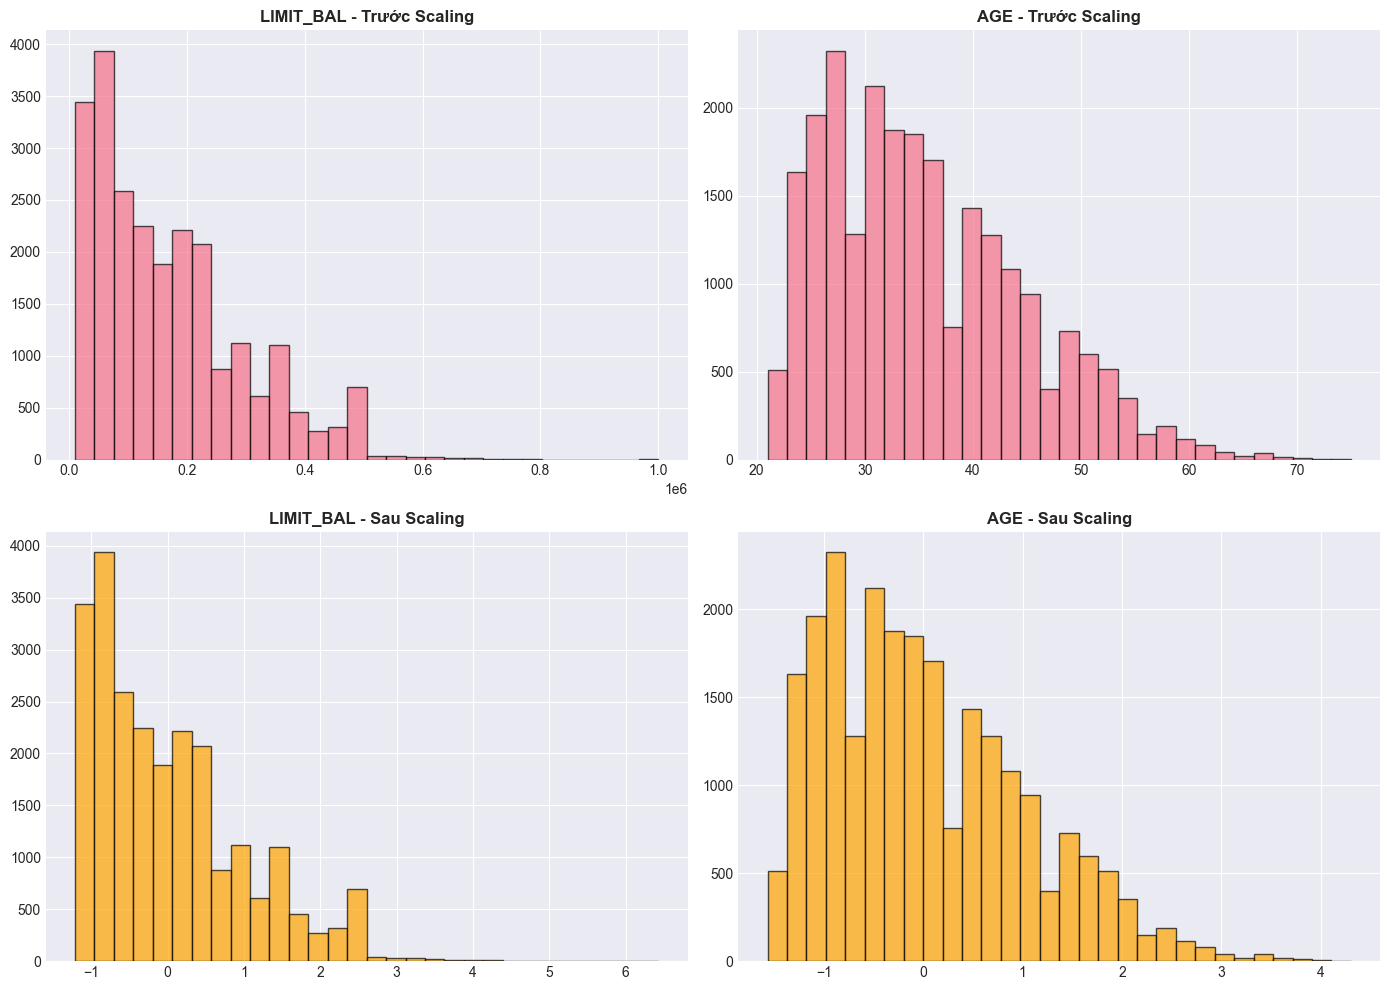

In [8]:
# Compare before and after scaling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Before scaling
X_train[['LIMIT_BAL', 'AGE']].hist(ax=axes[0], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('LIMIT_BAL - Trước Scaling', fontweight='bold')
axes[0, 1].set_title('AGE - Trước Scaling', fontweight='bold')

# After scaling
X_train_scaled[['LIMIT_BAL', 'AGE']].hist(ax=axes[1], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('LIMIT_BAL - Sau Scaling', fontweight='bold')
axes[1, 1].set_title('AGE - Sau Scaling', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/feature_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Xử lý Imbalanced Data

In [9]:
print("=" * 60)
print("XỬ LÝ IMBALANCED DATA")
print("=" * 60)

print("\nPhân phối ban đầu:")
print(y_train.value_counts())
print(f"Tỷ lệ: {y_train.value_counts()[0]/y_train.value_counts()[1]:.2f}:1")

XỬ LÝ IMBALANCED DATA

Phân phối ban đầu:
default
0    18691
1     5309
Name: count, dtype: int64
Tỷ lệ: 3.52:1


In [10]:
# Method 1: SMOTE (Synthetic Minority Over-sampling Technique)
print("\n1. SMOTE:")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"Shape sau SMOTE: {X_train_smote.shape}")
print(f"Distribution: {pd.Series(y_train_smote).value_counts().to_dict()}")

# Method 2: Random Undersampling
print("\n2. Random Undersampling:")
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)
print(f"Shape sau Undersampling: {X_train_rus.shape}")
print(f"Distribution: {pd.Series(y_train_rus).value_counts().to_dict()}")

# Method 3: SMOTE + Tomek (Combination)
print("\n3. SMOTETomek (Combination):")
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train_scaled, y_train)
print(f"Shape sau SMOTETomek: {X_train_smote_tomek.shape}")
print(f"Distribution: {pd.Series(y_train_smote_tomek).value_counts().to_dict()}")

print("\n✅ Đã tạo 3 versions của balanced dataset!")


1. SMOTE:


Shape sau SMOTE: (37382, 50)
Distribution: {0: 18691, 1: 18691}

2. Random Undersampling:
Shape sau Undersampling: (10618, 50)
Distribution: {0: 5309, 1: 5309}

3. SMOTETomek (Combination):


Shape sau SMOTETomek: (36704, 50)
Distribution: {0: 18352, 1: 18352}

✅ Đã tạo 3 versions của balanced dataset!


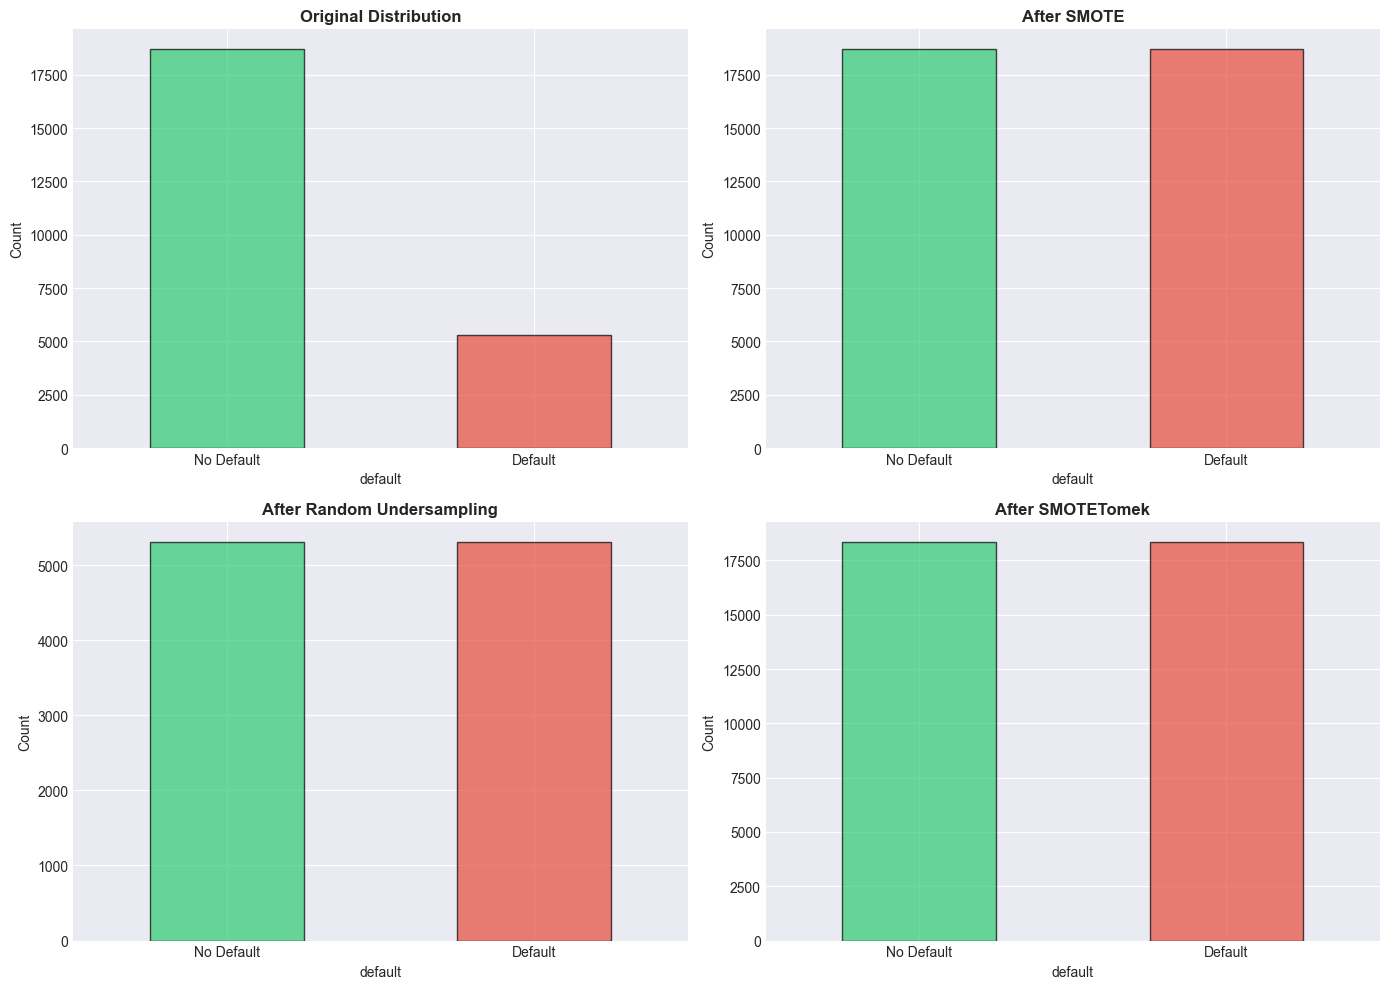

In [11]:
# Visualize class distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original
y_train.value_counts().plot(kind='bar', ax=axes[0, 0], color=['#2ecc71', '#e74c3c'], 
                            edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Original Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['No Default', 'Default'], rotation=0)

# SMOTE
pd.Series(y_train_smote).value_counts().plot(kind='bar', ax=axes[0, 1], 
                                             color=['#2ecc71', '#e74c3c'], 
                                             edgecolor='black', alpha=0.7)
axes[0, 1].set_title('After SMOTE', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(['No Default', 'Default'], rotation=0)

# Undersampling
pd.Series(y_train_rus).value_counts().plot(kind='bar', ax=axes[1, 0], 
                                           color=['#2ecc71', '#e74c3c'], 
                                           edgecolor='black', alpha=0.7)
axes[1, 0].set_title('After Random Undersampling', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticklabels(['No Default', 'Default'], rotation=0)

# SMOTETomek
pd.Series(y_train_smote_tomek).value_counts().plot(kind='bar', ax=axes[1, 1], 
                                                    color=['#2ecc71', '#e74c3c'], 
                                                    edgecolor='black', alpha=0.7)
axes[1, 1].set_title('After SMOTETomek', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticklabels(['No Default', 'Default'], rotation=0)

plt.tight_layout()
plt.savefig('../reports/figures/imbalanced_data_handling.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Lưu dữ liệu đã xử lý

In [12]:
print("=" * 60)
print("LƯU DỮ LIỆU ĐÃ XỬ LÝ")
print("=" * 60)

# Create a dictionary to save all datasets
data_dict = {
    'original': {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    },
    'smote': {
        'X_train': X_train_smote,
        'y_train': y_train_smote
    },
    'undersampling': {
        'X_train': X_train_rus,
        'y_train': y_train_rus
    },
    'smote_tomek': {
        'X_train': X_train_smote_tomek,
        'y_train': y_train_smote_tomek
    }
}

# Save as pickle
with open('../data/processed/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

print("\n✅ Đã lưu tất cả datasets vào: ../data/processed/preprocessed_data.pkl")

# Also save as CSV for reference
print("\nLưu CSV files...")
X_train_scaled.to_csv('../data/processed/X_train.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

print("✅ Đã lưu CSV files!")

# Save feature names
feature_names = list(X_train.columns)
with open('../data/processed/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
    
print("\n✅ Đã lưu feature names!")

LƯU DỮ LIỆU ĐÃ XỬ LÝ

✅ Đã lưu tất cả datasets vào: ../data/processed/preprocessed_data.pkl

Lưu CSV files...


✅ Đã lưu CSV files!

✅ Đã lưu feature names!


## 10. Tổng kết Data Preprocessing

In [13]:
print("\n" + "=" * 70)
print("TỔNG KẾT DATA PREPROCESSING & FEATURE ENGINEERING")
print("=" * 70)

print("\n📊 DỮ LIỆU:")
print(f"  • Total samples: {len(df):,}")
print(f"  • Total features: {X.shape[1]}")
print(f"  • Training samples: {len(X_train):,}")
print(f"  • Test samples: {len(X_test):,}")

print("\n🔧 XỬ LÝ:")
print("  ✅ Xử lý dữ liệu bất thường (EDUCATION, MARRIAGE)")
print("  ✅ Feature Engineering (27 features mới)")
print("  ✅ Feature Scaling (StandardScaler)")
print("  ✅ Imbalanced data handling (3 methods)")

print("\n📁 FILES ĐÃ LƯU:")
print("  • preprocessed_data.pkl - Tất cả datasets")
print("  • scaler.pkl - StandardScaler object")
print("  • feature_names.pkl - Danh sách features")
print("  • X_train.csv, X_test.csv, y_train.csv, y_test.csv")

print("\n🎯 BALANCED DATASETS:")
print("  1. Original: No resampling")
print(f"     Shape: {X_train_scaled.shape}")
print("  2. SMOTE: Synthetic oversampling")
print(f"     Shape: {X_train_smote.shape}")
print("  3. Undersampling: Random undersampling")
print(f"     Shape: {X_train_rus.shape}")
print("  4. SMOTETomek: Combination method")
print(f"     Shape: {X_train_smote_tomek.shape}")

print("\n" + "=" * 70)
print("✅ HOÀN THÀNH DATA PREPROCESSING!")
print("=" * 70)
print("\nTiếp theo: Notebook 03 - Model Training & Evaluation")


TỔNG KẾT DATA PREPROCESSING & FEATURE ENGINEERING

📊 DỮ LIỆU:
  • Total samples: 30,000
  • Total features: 50
  • Training samples: 24,000
  • Test samples: 6,000

🔧 XỬ LÝ:
  ✅ Xử lý dữ liệu bất thường (EDUCATION, MARRIAGE)
  ✅ Feature Engineering (27 features mới)
  ✅ Feature Scaling (StandardScaler)
  ✅ Imbalanced data handling (3 methods)

📁 FILES ĐÃ LƯU:
  • preprocessed_data.pkl - Tất cả datasets
  • scaler.pkl - StandardScaler object
  • feature_names.pkl - Danh sách features
  • X_train.csv, X_test.csv, y_train.csv, y_test.csv

🎯 BALANCED DATASETS:
  1. Original: No resampling
     Shape: (24000, 50)
  2. SMOTE: Synthetic oversampling
     Shape: (37382, 50)
  3. Undersampling: Random undersampling
     Shape: (10618, 50)
  4. SMOTETomek: Combination method
     Shape: (36704, 50)

✅ HOÀN THÀNH DATA PREPROCESSING!

Tiếp theo: Notebook 03 - Model Training & Evaluation
